In [1]:
!pip install thop

In [2]:
import argparse
import os

import pandas as pd
import torch
import torch.optim as optim
from thop import profile, clever_format
from torch.utils.data import DataLoader
from tqdm import tqdm

# import utils


from google.colab import drive
drive.mount('/content/gdrive/')

import sys
%cd /content/gdrive/MyDrive/'Colab Notebooks'/SimCLR
# from model import Model
from model_separation import Model
import utils
import linear

from torch import load

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/SimCLR


In [3]:
# parameters 

feature_dim = 128
temperature = 0.5
k = 200
# batch_size = 512
# epochs = 500
batch_size = 256
epochs = 100

# yjs added
gamma = 0.01 #0.2

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models.resnet import resnet50

# class Model(nn.Module):
#     def __init__(self, pretrained_path, feature_dim=128):
#         super(Model, self).__init__()

#         self.f = []
#         for name, module in resnet50().named_children():
#             if name == 'conv1':
#                 module = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
#             if not isinstance(module, nn.Linear) and not isinstance(module, nn.MaxPool2d):
#                 self.f.append(module)
#         # encoder
#         self.f = nn.Sequential(*self.f)
#         # projection head
#         self.g = nn.Sequential(nn.Linear(2048, 512, bias=False), nn.BatchNorm1d(512),
#                                nn.ReLU(inplace=True), nn.Linear(512, feature_dim, bias=True))
        
#         self.load_state_dict(torch.load(pretrained_path, map_location='cpu'), strict=False)

#     def forward(self, x):
#         x = self.f(x)
#         feature = torch.flatten(x, start_dim=1)
#         out = self.g(feature)
#         return F.normalize(feature, dim=-1), F.normalize(out, dim=-1)

class Net(nn.Module):
    def __init__(self, num_class, pretrained_path):
        super(Net, self).__init__()

        # encoder
        self.f = Model().f
        # classifier
        self.fc = nn.Linear(2048, num_class, bias=True)
        self.load_state_dict(torch.load(pretrained_path, map_location='cpu'), strict=False)

    def forward(self, x):
        x = self.f(x)
        x1 = x[:,:,0,:]
        x2 = x[:,:,1,:]

        feature1 = torch.flatten(x1, start_dim=1)
        feature2 = torch.flatten(x2, start_dim=1)
        # out1 = self.g1(feature1)
        # out2 = self.g2(feature2)
        # feature = torch.flatten(x, start_dim=1)
        #out = self.fc(feature1)
        return feature1, feature2
#model_path = 'results/model3_128_0.5_200_256_100_model.pth'
model = Net(num_class=10,pretrained_path='model3_128_0.5_200_256_100_model.pth').cuda()

In [5]:
from torchvision.datasets import CIFAR10
# train_data = CIFAR10(root='data', train=True, transform=utils.train_transform, download=True)
# train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=16, pin_memory=True)

# model = Net(num_class=len(train_data.classes), pretrained_path=model_path).cuda()
memory_data = utils.CIFAR10Pair(root='data', train=True, transform=utils.test_transform, download=True)
memory_data_loader = DataLoader(memory_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)
test_data = utils.CIFAR10Pair(root='data', train=False, transform=utils.test_transform, download=True)
test_data_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=16, pin_memory=True)


model.eval()
total_top1, total_top5, total_num, feature_bank1, feature_bank2 = 0.0, 0.0, 0, [], []
with torch.no_grad():


    for data, _, target in tqdm(memory_data_loader, desc='Feature extracting'):
        feature1, feature2 = model(data.cuda(non_blocking=True))
        feature_bank1.append(feature1)
        feature_bank2.append(feature2)
# [D, N]
feature_bank1 = torch.cat(feature_bank1, dim=0).t().contiguous()
feature_bank2 = torch.cat(feature_bank2, dim=0).t().contiguous()
# [N]
feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank1.device)

Files already downloaded and verified
Files already downloaded and verified


Feature extracting: 100%|██████████| 196/196 [00:28<00:00,  6.91it/s]


NameError: ignored

In [6]:
feature_labels = torch.tensor(memory_data_loader.dataset.targets, device=feature_bank1.device)

/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


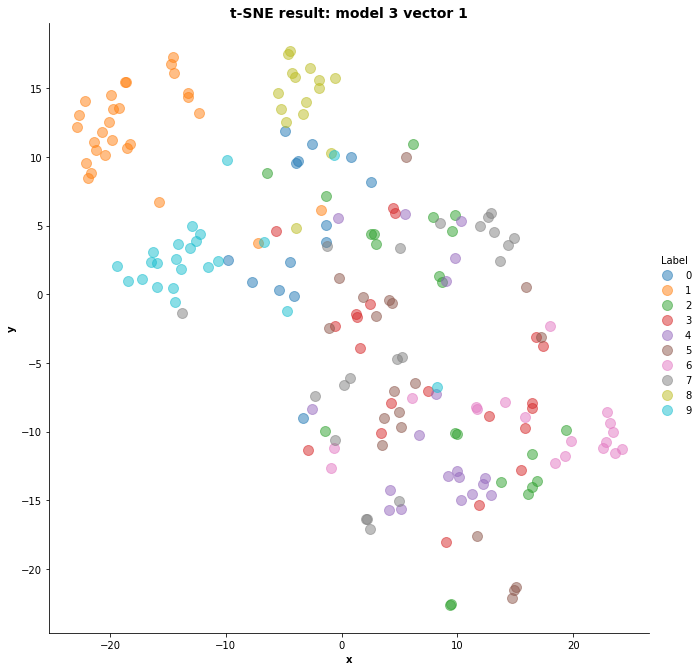

In [13]:
sub_bank1 = feature_bank1[:,:200]
sub_bank2 = feature_bank2[:,:200]
sub_label = feature_labels[:200]

from sklearn.manifold import TSNE
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
test_features = np.transpose(sub_bank1.cpu())
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_ref = tsne.fit_transform(test_features)
df = pd.DataFrame(tsne_ref, index=tsne_ref[0:,1])
df['x'] = tsne_ref[:,0]
df['y'] = tsne_ref[:,1]
df['Label'] = sub_label.cpu()[:]
# sns.scatterplot(x="x", y="y", hue="y", palette=sns.color_palette("hls", 10), data=df)

sns.lmplot(x="x", y="y", data=df, fit_reg=False, legend=True, size=9, hue='Label', scatter_kws={"s":100, "alpha":0.5})
plt.title('t-SNE result: model 3 vector 1', weight='bold').set_fontsize('14')
plt.xlabel('x', weight='bold').set_fontsize('10')
plt.ylabel('y', weight='bold').set_fontsize('10')
plt.show()

# perplexity = 10
# p = figure(width=600, height=600, title='perplexity = {:.2f}'.format(perplexity))
# z = TSNE(n_components=2, perplexity=perplexity).fit_transform(sub_bank)


/usr/local/lib/python3.6/dist-packages/seaborn/regression.py:580: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


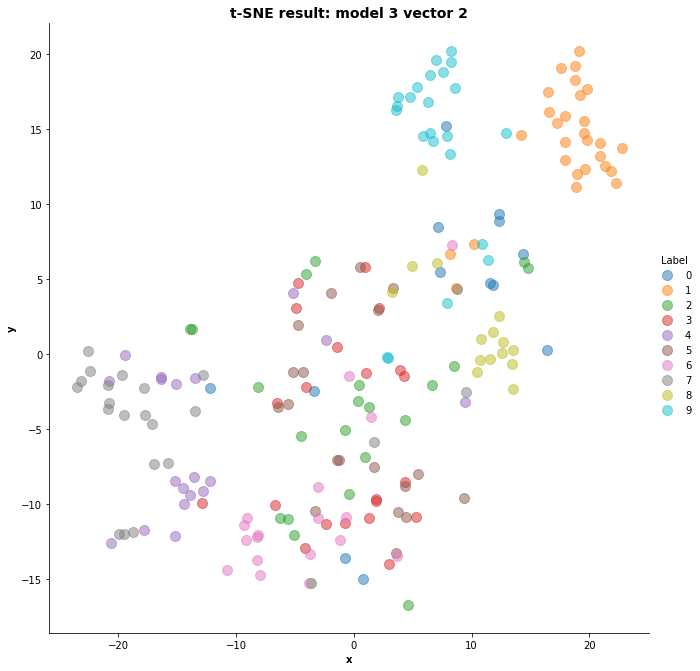

In [10]:
test_features = np.transpose(sub_bank2.cpu())
tsne = TSNE(n_components=2, perplexity=10, n_iter=300)
tsne_ref = tsne.fit_transform(test_features)
df = pd.DataFrame(tsne_ref, index=tsne_ref[0:,1])
df['x'] = tsne_ref[:,0]
df['y'] = tsne_ref[:,1]
df['Label'] = sub_label.cpu()[:]
# sns.scatterplot(x="x", y="y", hue="y", palette=sns.color_palette("hls", 10), data=df)

sns.lmplot(x="x", y="y", data=df, fit_reg=False, legend=True, size=9, hue='Label', scatter_kws={"s":100, "alpha":0.5})
plt.title('t-SNE result: model 3 vector 2', weight='bold').set_fontsize('14')
plt.xlabel('x', weight='bold').set_fontsize('10')
plt.ylabel('y', weight='bold').set_fontsize('10')
plt.show()